# CIFAR-10 Classification Demo

This notebook demonstrates how to use Complete Confusion to evaluate a CNN classifier trained on the CIFAR-10 dataset.

## Overview

We'll:
1. Download and preprocess CIFAR-10 data
2. Build and train a simple CNN classifier
3. Evaluate the model's performance
4. Use Complete Confusion to generate comprehensive performance reports

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 classes:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

## Import Libraries

First, let's import all necessary libraries:

In [10]:
import complete_confusion as cc
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
PyTorch version: 2.8.0
Device available: CPU


## Download and Prepare CIFAR-10 Data

Let's download the CIFAR-10 dataset and prepare it for training:

In [15]:
# Create data directory
data_dir = Path.home() / "cifar10_data"
data_dir.mkdir(exist_ok=True)

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(
    root=str(data_dir), train=True, download=True, transform=transform_train
)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=str(data_dir), train=False, download=True, transform=transform_test
)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Training samples: 50000
Test samples: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 50000
Test samples: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualize Sample Data

Let's look at some sample images from the dataset:

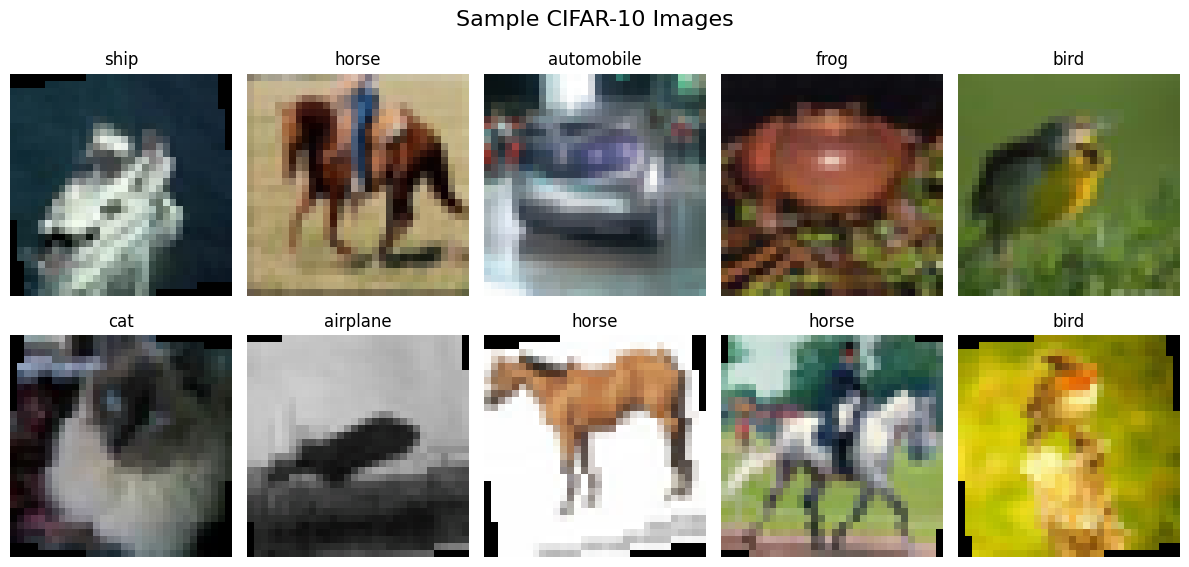

Displayed 128 sample images


In [16]:
# Function to denormalize images for visualization
def denormalize(tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample CIFAR-10 Images', fontsize=16)

for i in range(10):
    row = i // 5
    col = i % 5
    
    # Denormalize and convert to displayable format
    img = denormalize(images[i])
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0)
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{class_names[labels[i]]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Displayed {len(images)} sample images")

## Define CNN Architecture

Let's create a simple but effective CNN for CIFAR-10 classification:

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Third convolutional block
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=10).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model will train on: {device}")

Model created successfully!
Total parameters: 1,342,122
Trainable parameters: 1,342,122
Model will train on: cpu


## Train the Model

Now let's train our CNN on the CIFAR-10 dataset:

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(trainloader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Train the model (reduced epochs for demo)
num_epochs = 5  # You can increase this for better performance
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print(f"Starting training for {num_epochs} epochs...")
print("Note: This is a simplified demo. For better results, train for more epochs.")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, testloader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("\nTraining completed!")

Starting training for 5 epochs...
Note: This is a simplified demo. For better results, train for more epochs.

Epoch 1/5
--------------------------------------------------
Batch 0/391, Loss: 2.4385, Acc: 10.16%
Batch 100/391, Loss: 1.7061, Acc: 27.22%
Batch 200/391, Loss: 1.6024, Acc: 32.38%
Batch 300/391, Loss: 1.7929, Acc: 35.41%
Train Loss: 1.6892, Train Acc: 37.31%
Val Loss: 1.3277, Val Acc: 51.95%

Epoch 2/5
--------------------------------------------------
Batch 0/391, Loss: 1.5207, Acc: 39.06%
Batch 100/391, Loss: 1.5369, Acc: 46.94%
Batch 200/391, Loss: 1.3743, Acc: 48.24%
Batch 300/391, Loss: 1.3929, Acc: 49.28%
Train Loss: 1.3821, Train Acc: 50.08%
Val Loss: 1.1166, Val Acc: 59.40%

Epoch 3/5
--------------------------------------------------
Batch 0/391, Loss: 1.4438, Acc: 52.34%
Batch 100/391, Loss: 1.2506, Acc: 54.91%
Batch 200/391, Loss: 1.3397, Acc: 55.82%
Batch 300/391, Loss: 1.2345, Acc: 56.20%
Train Loss: 1.2188, Train Acc: 56.65%
Val Loss: 0.9464, Val Acc: 66.82%

E

## Plot Training History

Let's visualize the training progress:

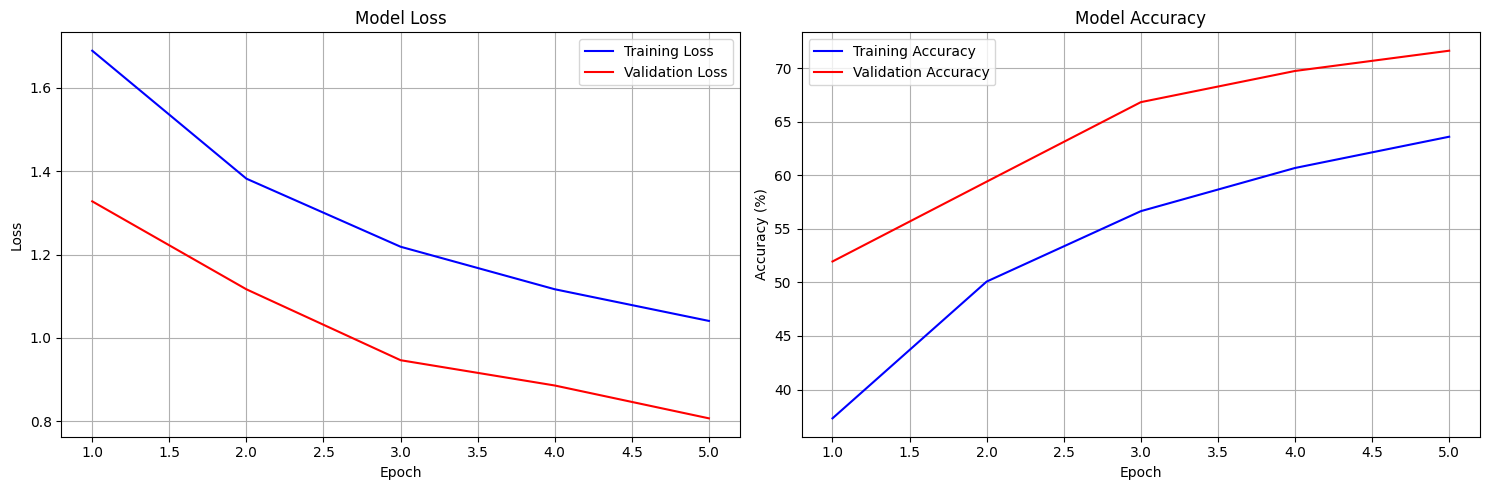

Final validation accuracy: 71.62%


In [6]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
epochs_range = range(1, num_epochs + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs_range, train_accs, 'b-', label='Training Accuracy')
ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final validation accuracy: {val_accs[-1]:.2f}%")

## Get Model Predictions

Now let's get predictions on the test set to evaluate with Complete Confusion:

In [17]:
# Get predictions on test set
model.eval()
all_predictions = []
all_true_labels = []

print("Getting predictions on test set...")
with torch.no_grad():
    for data, target in testloader:
        data = data.to(device)
        output = model(data)
        _, predicted = output.max(1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(target.numpy())

# Convert to numpy arrays
predictions = np.array(all_predictions)
true_labels = np.array(all_true_labels)

print(f"Collected {len(predictions)} predictions")
print(f"Test accuracy: {100 * (predictions == true_labels).mean():.2f}%")
print(f"Predictions shape: {predictions.shape}")
print(f"True labels shape: {true_labels.shape}")

Getting predictions on test set...
Collected 10000 predictions
Test accuracy: 71.62%
Predictions shape: (10000,)
True labels shape: (10000,)
Collected 10000 predictions
Test accuracy: 71.62%
Predictions shape: (10000,)
True labels shape: (10000,)


## Generate Complete Confusion Report

Now let's use Complete Confusion to generate a comprehensive performance report:

In [20]:
# Create output directory
output_dir = "cifar10_performance"
os.makedirs(output_dir, exist_ok=True)

# Create subdirectory for images
images_dir = os.path.join(output_dir, "images")
os.makedirs(images_dir, exist_ok=True)

# Convert CIFAR-10 test images and save as separate files
from PIL import Image

def save_cifar_image(img_array, output_path):
    """Convert a CIFAR-10 image array and save as PNG file."""
    # Convert from tensor format (C, H, W) to image format (H, W, C) if needed
    if img_array.shape[0] == 3:  # Channel first
        img_array = np.transpose(img_array, (1, 2, 0))
    
    # Convert to uint8 (data is already in [0,1] range from ToTensor())
    img_array = (img_array * 255).astype(np.uint8)
    
    # Create PIL image
    img = Image.fromarray(img_array)
    
    # Resize for better visibility in the report (CIFAR-10 images are quite small)
    img = img.resize((64, 64), Image.NEAREST)  # 2x upscale with nearest neighbor to keep pixelated look
    
    # Save as PNG file
    img.save(output_path, format='PNG')

print("Saving ALL test images as separate files...")
print("📁 Images will be saved in the 'images/' subdirectory")

# Get original test data (without normalization) for clean image display
testset_original = torchvision.datasets.CIFAR10(
    root=str(data_dir), train=False, download=False, 
    transform=transforms.ToTensor()  # Only convert to tensor, no normalization
)

# Create image file paths for ALL test samples
image_file_paths = []

print(f"Processing {len(testset_original)} images...")
for idx in range(len(testset_original)):
    if idx % 1000 == 0:  # Progress indicator
        print(f"  Processed {idx}/{len(testset_original)} images...")
    
    img_tensor, true_label = testset_original[idx]
    img_array = img_tensor.numpy()
    
    # Create filename and save image
    img_filename = f"cifar10_test_{idx:05d}.png"
    img_path = os.path.join(images_dir, img_filename)
    save_cifar_image(img_array, img_path)
    
    # Store relative path for the HTML report
    relative_path = f"images/{img_filename}"
    image_file_paths.append(relative_path)

print(f"Saved {len(image_file_paths)} image files")

# Generate comprehensive performance report with image file references
print("Generating Complete Confusion performance report with image file references...")
print("🚀 This will be much faster than embedding base64 images!")
cc.save_performance_metrics_to_html(
    predictions.tolist(),
    true_labels.tolist(),
    class_names,
    image_representations=image_file_paths,
    output_path=output_dir
)

print(f"\nCIFAR-10 CNN performance report generated!")
print(f"Open '{output_dir}/complete-confusion.html' in your browser to view the interactive report.")
print(f"\nThe report includes:")
print(f"- Interactive confusion matrix with all 10 classes")
print(f"- Per-class precision, recall, and F1-score")
print(f"- Overall accuracy and performance statistics")
print(f"- ALL {len(image_file_paths)} CIFAR-10 test images as separate files!")
print(f"- Detailed analysis of classification errors")
print(f"- Hover tooltips for detailed information")
print(f"\n💡 Images are stored as separate files with relative URLs!")
print(f"📁 Structure:")
print(f"   {output_dir}/")
print(f"   ├── complete-confusion.html  (main report)")
print(f"   └── images/                  ({len(image_file_paths)} image files)")
print(f"📊 HTML file size: ~1-5MB (much smaller!)")
print(f"🖼️  Image files: ~{len(image_file_paths) * 8 // 1000}MB total")

Saving ALL test images as separate files...
📁 Images will be saved in the 'images/' subdirectory
Processing 10000 images...
  Processed 0/10000 images...
Processing 10000 images...
  Processed 0/10000 images...
  Processed 1000/10000 images...
  Processed 1000/10000 images...
  Processed 2000/10000 images...
  Processed 2000/10000 images...
  Processed 3000/10000 images...
  Processed 3000/10000 images...
  Processed 4000/10000 images...
  Processed 4000/10000 images...
  Processed 5000/10000 images...
  Processed 5000/10000 images...
  Processed 6000/10000 images...
  Processed 6000/10000 images...
  Processed 7000/10000 images...
  Processed 7000/10000 images...
  Processed 8000/10000 images...
  Processed 8000/10000 images...
  Processed 9000/10000 images...
  Processed 9000/10000 images...
Saved 10000 image files
Generating Complete Confusion performance report with image file references...
🚀 This will be much faster than embedding base64 images!

CIFAR-10 CNN performance report ge

## Image Inclusion Strategies Explained

### What We Just Did

We embedded CIFAR-10 images directly into the Complete Confusion HTML report using **base64 data URIs**. Here's why this approach is excellent:

#### ✅ **Advantages of Data URI Approach**

1. **Self-contained reports** - No external image files needed
2. **Portable** - Report works anywhere, even offline
3. **Version controlled** - Images are part of the HTML file
4. **No broken links** - Images can't get separated from the report
5. **GitHub Pages friendly** - No complex asset management needed

#### 🔧 **How It Works**

```python
# Convert numpy array → PIL Image → PNG bytes → base64 → data URI
data_uri = f"data:image/png;base64,{base64_string}"
```

The Complete Confusion library receives these data URIs and embeds them directly as `<img src="data:image/png;base64,...">` tags.

#### 📊 **Alternative Approaches**

**1. File-based approach:**
```python
# Save images as files and provide file paths
image_paths = [f"images/sample_{i}.png" for i in range(len(predictions))]
```
- ✅ Smaller HTML files
- ❌ Need to manage separate image files
- ❌ Can break if images are moved

**2. Numpy array compression (your original idea):**
```python
# Hypothetically: store as compressed numpy and unpack in JS
compressed_array = compress_numpy_array(image_data)
```
- ✅ Efficient storage
- ❌ Would require custom JavaScript in the HTML template
- ❌ Complex implementation

**3. Hybrid approach:**
```python
# Use data URIs for small datasets, file paths for large ones
if len(images) < 100:
    use_data_uris()
else:
    save_as_files()
```

#### 💡 **Best Practices**

- **Limit image count** (50-100 max) to keep HTML size reasonable
- **Resize images** appropriately (64x64 is good for CIFAR-10)
- **Focus on interesting examples** (misclassifications, edge cases)
- **Use efficient formats** (PNG for screenshots, JPEG for photos)

#### 🎯 **Perfect Use Cases**

- **Error analysis** - See exactly which images were misclassified
- **Data quality** - Spot labeling errors or corrupted images  
- **Model debugging** - Understand systematic failures
- **Stakeholder demos** - Show real examples with predictions